In [1]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from splot.mapping import vba_choropleth, vba_legend, mapclassify_bin
from shapely.geometry import Point, Polygon, LineString
import libpysal.weights as sw 
from esda.moran import Moran_Local, Moran
from splot.esda import lisa_cluster, plot_local_autocorrelation, plot_moran
import warnings
import census
import us
import rasterio
warnings.simplefilter("ignore") 




from rasterio.plot import show
import requests
import rasterstats as rstats


/home/liuz/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [111]:
with rasterio.open('../2021-09-19-NDVI.tiff') as src:
    ndvi = src.read(1, window= rasterio.windows.from_bounds(-8266069.89886961,  4938302.3518047 , -8204449.4381029 ,
        4999279.62331638, src.transform))
    affine=src.transform
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 2500, 'height': 1270, 'count': 3, 'crs': CRS.from_wkt('LOCAL_CS["Popular Visualisation Pseudo Mercator",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(22.013864146130533, 0.0, -8260022.64929883,
       0.0, -22.02830893887559, 4995077.091183007), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}


array([[    0.,     0.,     0., ..., 49152., 49152., 49152.],
       [ 8520.,  3932.,     0., ..., 49152., 49152., 49152.],
       [60948., 57016., 24904., ..., 49152., 49152., 49152.],
       ...,
       [57016., 65535., 60293., ...,  3932., 24904., 20316.],
       [60948., 60948., 57016., ..., 28836., 16384., 24904.],
       [65535., 52429., 52429., ..., 24904., 32768., 45220.]])

In [123]:
res = (32768 - ndvi.astype(float))/32768

Text(0, 0.5, 'Row #')

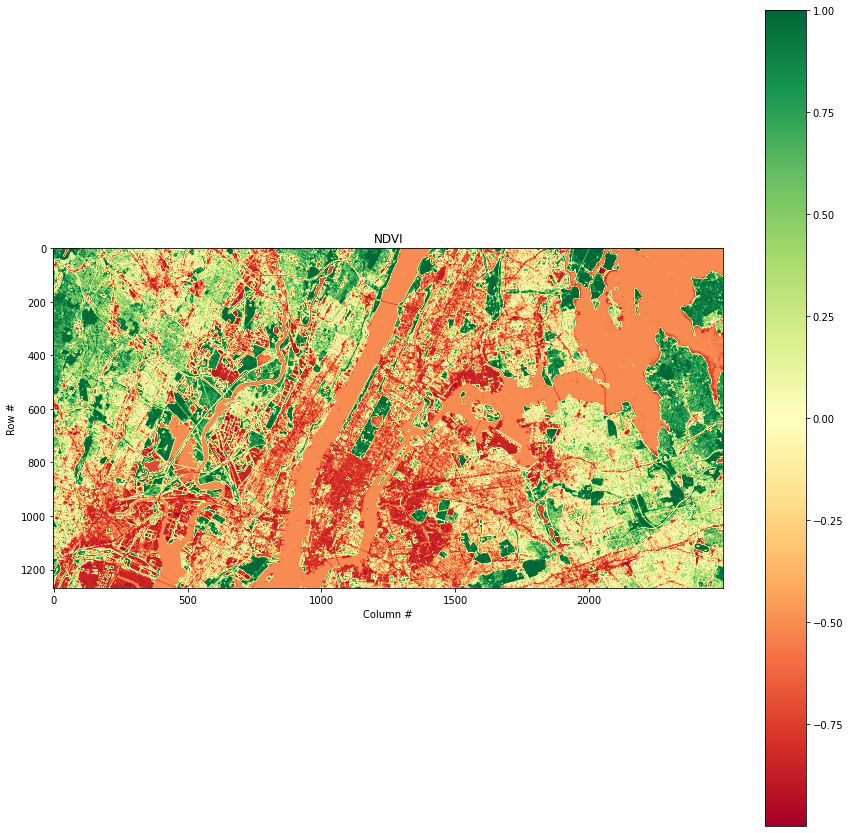

In [125]:
plt.figure(figsize = (15,15))
plt.imshow(res, cmap='RdYlGn') 
plt.colorbar()
plt.title('NDVI')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [91]:
with rasterio.open('../red4.tiff') as src:
    red = src.read(1, window=rasterio.windows.from_bounds(-8266069.89886961,  4938302.3518047 , -8204449.4381029 ,
        4999279.62331638, src.transform))
    profile=src.profile

with rasterio.open('../nir8.tiff') as src:
    nir = src.read(1, window=rasterio.windows.from_bounds(-8266069.89886961,  4938302.3518047 , -8204449.4381029 ,
        4999279.62331638, src.transform))
    transform = src.transform

In [92]:
transform

Affine(93.92582035682425, 0.0, -8363495.021544366,
       0.0, -93.9421667922144, 5026226.02016305)

In [8]:
src = rasterio.open('../nir8.tiff')

In [13]:
src.

In [39]:
red.shape

(649, 656)

In [44]:
unique, counts = np.unique(red, return_counts=True)
df2 = pd.DataFrame({'DN':unique, 'counts':counts})

In [32]:
unique, counts = np.unique(nir, return_counts=True)
df = pd.DataFrame({'DN':unique, 'counts':counts})

In [38]:
df[df.DN <= 10000].counts.sum()

204375

<AxesSubplot:xlabel='DN'>

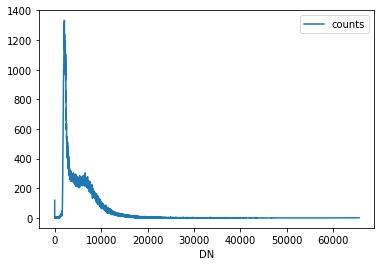

In [45]:
df2.plot.line(x='DN',y='counts')

<AxesSubplot:xlabel='DN'>

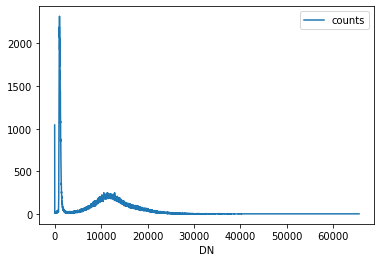

In [43]:
df.plot.line(x='DN',y='counts')

In [41]:
df[df.DN > 12000].counts.sum()

159291

In [24]:
nir.shape

(649, 656)

In [25]:
red.shape

(649, 656)

In [26]:
def calc_ndvi(nir, red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype(np.float)
    red = red.astype(np.float)
    ndvi = (nir - red) / (nir + red)
    return ndvi

In [27]:
ndvi=calc_ndvi(nir, red)

In [28]:
ndvi

array([[ 0.71018105, -1.        , -1.        , ..., -0.3266848 ,
        -0.33992806, -0.36200942],
       [ 0.5694367 ,  0.36788538,  0.09222222, ..., -0.33876528,
        -0.34021263, -0.34682441],
       [ 0.73158578,  0.640571  ,  0.72563576, ..., -0.36094298,
        -0.34021263, -0.34128728],
       ...,
       [-0.30759728, -0.28700906, -0.28645674, ..., -0.30664761,
        -0.28662873, -0.27874564],
       [-0.31170837, -0.30036408, -0.308933  , ..., -0.30232558,
        -0.30664761, -0.27065712],
       [-0.32246945, -0.31562693, -0.30329397, ..., -0.32455461,
        -0.28280702, -0.34115921]])

In [31]:
np.isnan(ndvi)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
np.count_nonzero(np.isnan(ndvi))

41

Text(0, 0.5, 'Row #')

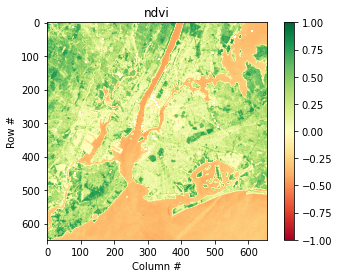

In [90]:
ndvi

array([[ 0.71018105, -1.        , -1.        , ..., -0.3266848 ,
        -0.33992806, -0.36200942],
       [ 0.5694367 ,  0.36788538,  0.09222222, ..., -0.33876528,
        -0.34021263, -0.34682441],
       [ 0.73158578,  0.640571  ,  0.72563576, ..., -0.36094298,
        -0.34021263, -0.34128728],
       ...,
       [-0.30759728, -0.28700906, -0.28645674, ..., -0.30664761,
        -0.28662873, -0.27874564],
       [-0.31170837, -0.30036408, -0.308933  , ..., -0.30232558,
        -0.30664761, -0.27065712],
       [-0.32246945, -0.31562693, -0.30329397, ..., -0.32455461,
        -0.28280702, -0.34115921]])

TypeError: colorbar() missing 1 required positional argument: 'mappable'

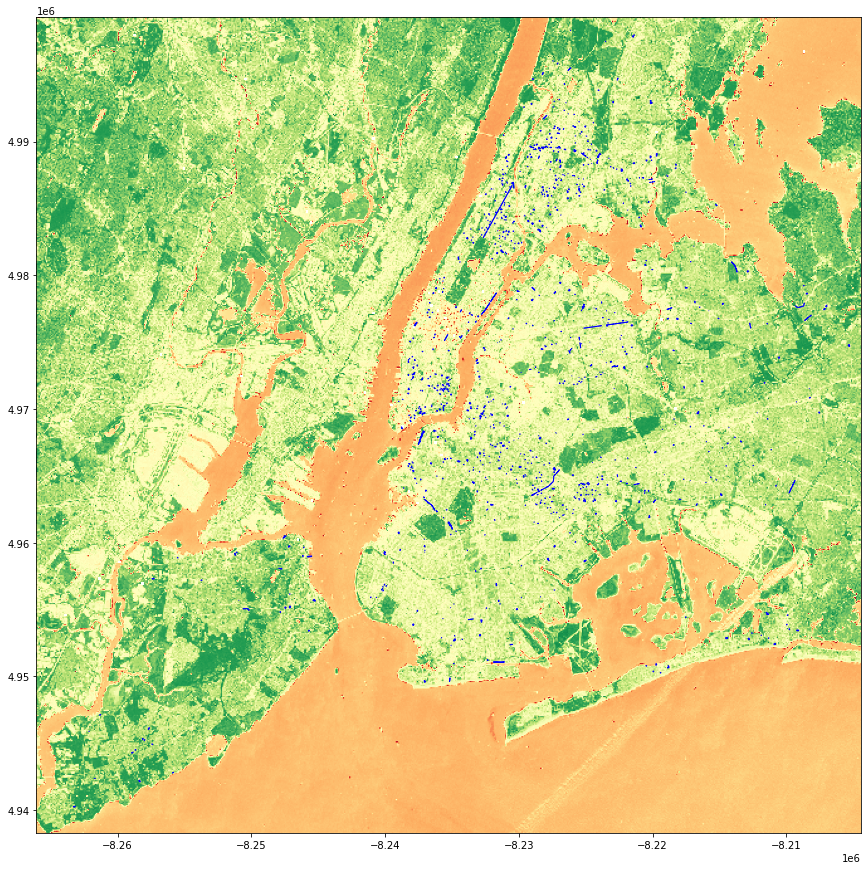

In [110]:
fig,ax = plt.subplots(figsize=(15,15))

rasterio.plot.show(ndvi, ax=ax,cmap='RdYlGn',transform=rasterio.transform.from_origin(-8266069.89886961, 4999279.62331638, 93.92582035682425, 93.9421667922144 )
)
nap.plot(ax=ax,legend=True,facecolor='none', edgecolor='blue')
fig.colorbar()
# plt.title('ndvi')
# plt.xlabel('Column #')
# plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

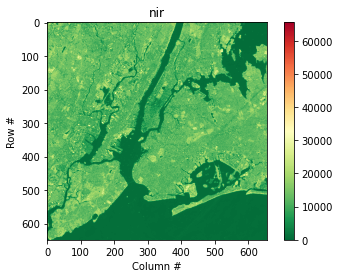

In [23]:
plt.imshow(nir, cmap='RdYlGn_r') 
plt.colorbar()
plt.title('nir')
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

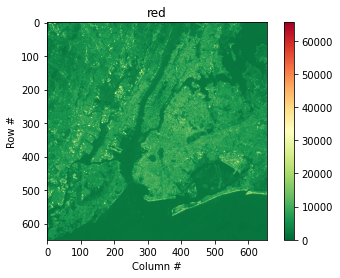

In [21]:
plt.imshow(red, cmap='RdYlGn_r') 
plt.colorbar()
plt.title('red')
plt.xlabel('Column #')
plt.ylabel('Row #')

In [47]:
parks = gpd.read_file('../parks/nyc_parks.shp')

<AxesSubplot:>

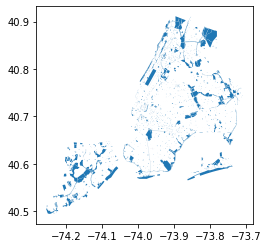

In [52]:
parks.plot()

In [48]:
parks=parks[(parks['landuse']=='Neighborhood Park') | (parks['landuse']=='Community Park') |(parks['landuse']=='Nature Area') |(parks['landuse']=='Garden') | (parks['landuse']=='Flagship Park')]

KeyError: 'landuse'

In [53]:
transform=rasterio.transform.from_origin(-8266069.89886961, 4999279.62331638, 93.92582035682425, 93.9421667922144 )
with rasterio.open('../nyc_ndvi1.tif', 'w', driver='GTiff', 
                   height=ndvi.shape[0], width=ndvi.shape[1], 
                   count=1, dtype=ndvi.dtype, 
                   crs='+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs',
                   transform=transform ) as output:
    output.write(ndvi,1) 
    output.close()  

In [55]:
with rasterio.open("../nyc_ndvi1.tif", "r+") as dataset:
    dataset.nodata = np.nan

In [56]:
with rasterio.open('../nyc_ndvi1.tif') as src:
    ndvi = src.read(1, window= rasterio.windows.from_bounds(-8266069.89886961,  4938302.3518047 , -8204449.4381029 ,
        4999279.62331638, src.transform))
    affine=src.transform
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 656, 'height': 649, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS_84_Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]'), 'transform': Affine(93.92582035682425, 0.0, -8266069.89886961,
       0.0, -93.9421667922144, 4999279.62331638), 'tiled': False, 'interleave': 'band'}


In [60]:
ndvi

array([[ 0.71018105, -1.        , -1.        , ..., -0.3266848 ,
        -0.33992806, -0.36200942],
       [ 0.5694367 ,  0.36788538,  0.09222222, ..., -0.33876528,
        -0.34021263, -0.34682441],
       [ 0.73158578,  0.640571  ,  0.72563576, ..., -0.36094298,
        -0.34021263, -0.34128728],
       ...,
       [-0.30759728, -0.28700906, -0.28645674, ..., -0.30664761,
        -0.28662873, -0.27874564],
       [-0.31170837, -0.30036408, -0.308933  , ..., -0.30232558,
        -0.30664761, -0.27065712],
       [-0.32246945, -0.31562693, -0.30329397, ..., -0.32455461,
        -0.28280702, -0.34115921]])

In [62]:
parks = parks.to_crs(epsg='3857')

In [63]:
parks.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
parks_ndvi = rstats.zonal_stats(parks.geometry, '../nyc_ndvi1.tif')


In [ ]:
parks_ndvi

In [66]:
avg = [r['mean'] for r in parks_ndvi]

parks['avg_ndvi'] = avg

In [109]:
nap = parks[parks['avg_ndvi'].isnull()]